# Polars

In [5]:
import polars as pl

### Load Data

In [6]:
DATA_DIR = "../data/dota"

In [7]:
pl_match = pl.scan_csv(f"{DATA_DIR}/match.csv")
pl_cluster_regions = pl.scan_csv(f"{DATA_DIR}/cluster_regions.csv")
pl_purchase_log = pl.scan_csv(f"{DATA_DIR}/purchase_log.csv")
pl_item_id_names = pl.scan_csv(f"{DATA_DIR}/item_ids.csv")
pl_players = pl.scan_csv(f"{DATA_DIR}/players.csv")

In [14]:
# add region names to match data

match_with_region = pl_match.join(pl_cluster_regions, how="left", on="cluster").drop("cluster")

In [9]:
# add item names to item purchases

purchases_with_item_names = (
    pl_purchase_log
    .join(pl_item_id_names, how="left", on="item_id")
    .drop("item_id")
    .groupby(["match_id", "player_slot", "item_name"]).agg(pl.col("time").list().keep_name())
    .groupby(["match_id", "player_slot"]).agg(
        [
            pl.apply(
                [pl.col("item_name"), pl.col("time")],
                lambda s: dict(zip(s[0], s[1].to_list())),
            ).alias("purchases")
        ]
    )
)

In [10]:
# add match and item information to player data

pl_final_lazy = (pl_players
    .filter(pl.col("account_id") != 0)
    .join(purchases_with_item_names, on=["match_id", "player_slot"])
    .join(match_with_region, how="left", on="match_id")
    )


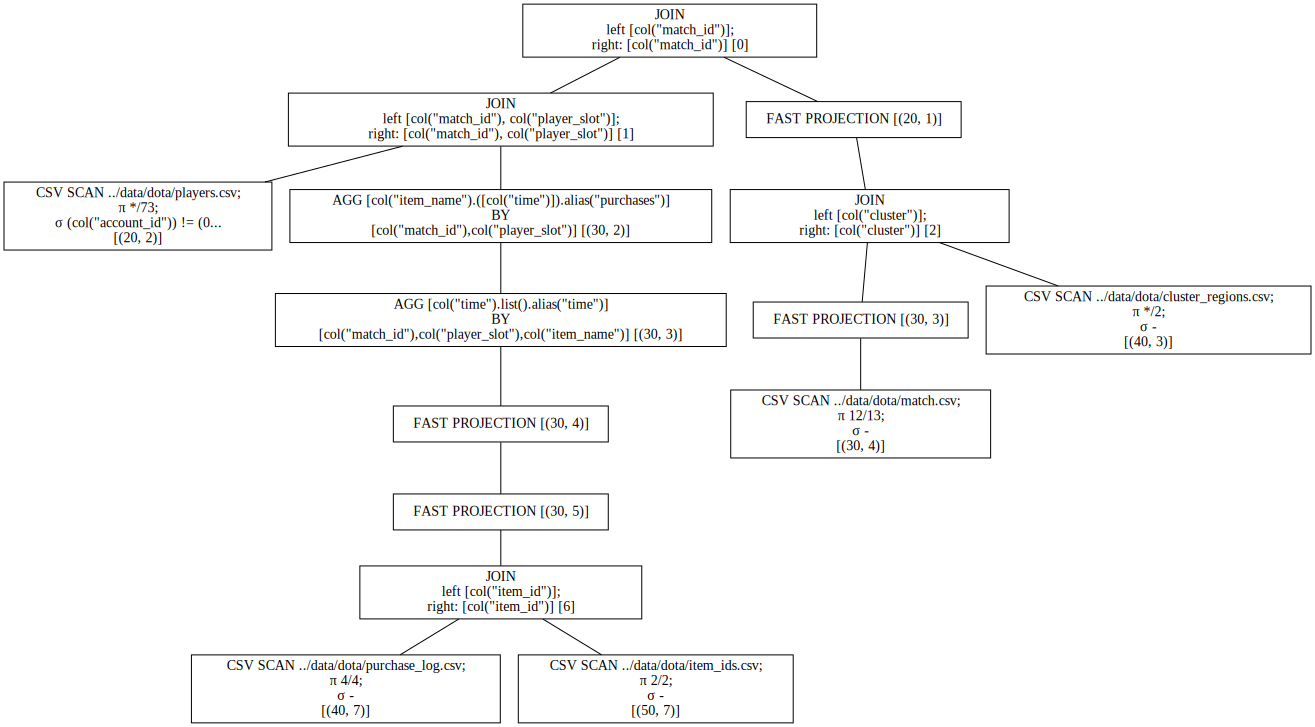

In [12]:
pl_final_lazy.show_graph(optimized=True)

In [8]:
pl_final = pl_final_lazy.collect()

# drop cols with more than 20% NaN
pl_final = pl_final[
            :,
            [
                pl_final[col].null_count() <= 0.2 * pl_final.height
                for col in pl_final.columns
                if col not in ["purchases"]
            ]
            + ["purchases"],
        ]